# Part 1: Exploratory Data Analysis

In [1]:
#Importing necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
from datetime import datetime

In [2]:
login_data = pd.read_json("logins.json")
login_data['login_count'] = 1
login_data = login_data.set_index(pd.to_datetime(login_data['login_time'], unit='s'))[['login_count']]
login_data

login_count
login_time                      
1970-01-01 20:13:18            1
1970-01-01 20:16:10            1
1970-01-01 20:16:37            1
1970-01-01 20:16:36            1
1970-01-01 20:26:21            1
...                          ...
1970-04-13 18:50:19            1
1970-04-13 18:43:56            1
1970-04-13 18:54:02            1
1970-04-13 18:57:38            1
1970-04-13 18:54:23            1

[93142 rows x 1 columns]

In [3]:
#Aggregating data on 15 minute intervals
delta = login_data.resample('15Min').sum()
     
#Sorting results to display top 10
delta.sort_values('login_count', ascending = False).head(10)

login_count
login_time                      
1970-03-01 04:30:00           73
1970-04-04 05:30:00           66
1970-04-04 01:30:00           64
1970-04-04 01:15:00           63
1970-04-01 23:30:00           60
1970-04-04 05:00:00           60
1970-04-04 04:45:00           59
1970-04-04 05:15:00           59
1970-04-04 01:45:00           56
1970-03-13 22:15:00           55

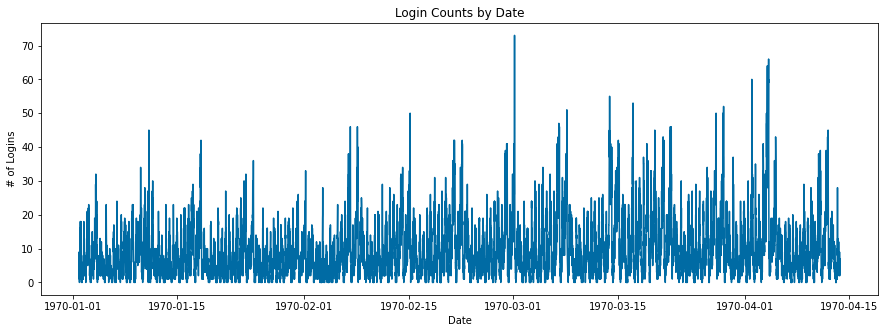

In [4]:
#initial data visualization
fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Date')
plt.ylabel('# of Logins')
plt.title('Login Counts by Date')
plt.plot(delta.index, delta.login_count);

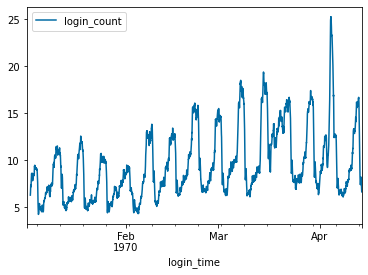

In [5]:
#Rolling chart used to better view the congested data.
delta.rolling(window=100).mean().plot()
plt.show()

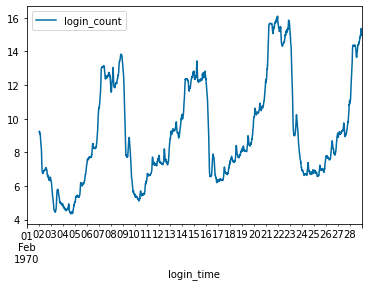

In [6]:
#Plot of only februrary
delta.loc['1970-02'].rolling(window=100).mean().plot()
plt.show()

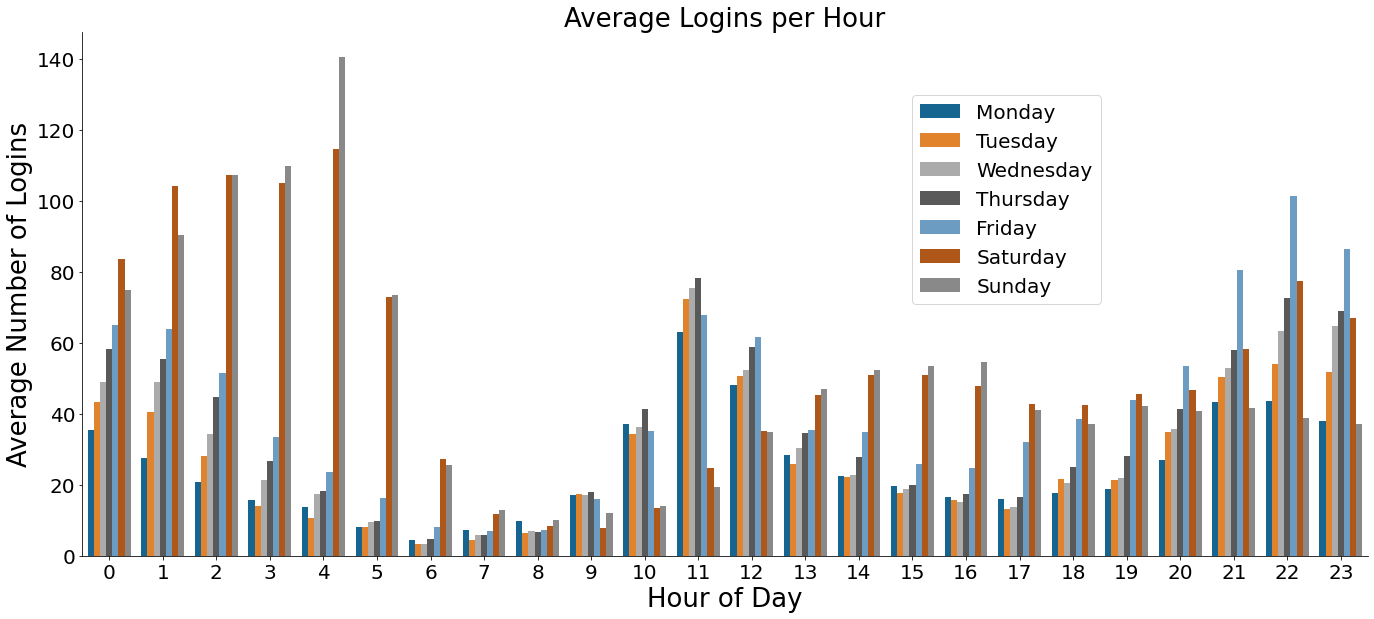

In [7]:
# resample index hourly
daily_logins = delta.resample('H').sum()
# make a column that identify the day of week; Monday=0, Sunday=6
day_of_week = list(daily_logins.index.dayofweek)
daily_logins['day_of_week'] = day_of_week
# add column with just the hour (omiting the date)
daily_logins['hour'] = [time.hour for time in daily_logins.index]

# create dataframe of the average number of logins for each hour of each day
avg_hourly_logins = pd.pivot_table(daily_logins, values = 'login_count', index = 'hour',
                                   columns = 'day_of_week', aggfunc=np.mean).rename(
    columns= {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})

avg_hourly_logins = avg_hourly_logins.stack(level=['day_of_week'])


avg_hourly_logins.name = 'avg_num_logins'
avg_hourly_logins_df = avg_hourly_logins.reset_index()


sns.catplot(x='hour', y='avg_num_logins', data=avg_hourly_logins_df, kind = 'bar', 
            hue='day_of_week',height=8, aspect=11.7/5, legend=False)

ax = plt.gca()
ax.set_title('Average Logins per Hour', fontsize = 26)
ax.set_xlabel('Hour of Day', fontsize = 26)
ax.set_ylabel('Average Number of Logins', fontsize = 26)
ax.tick_params(labelsize=20,labelcolor="black")
ax.legend(bbox_to_anchor=(0.7,0.7,0.1, 0.2),fontsize=20);

# Part 2: Experiment and Metrics Design

To measure the success of the experiment, I would choose the number of toll reimbursement requests filed as the key metric. This metric directly reflects the usage of the program and indicates how many drivers are willing to serve both cities.

To compare the effectiveness of the proposed change, I would design a practical experiment with the following details:

a) Implementation of the experiment:

1. Establish a control group: Select a sample population of drivers who will not be reimbursed for toll costs during the experimental period.
2. Baseline data collection: Monitor the toll bridge crossings by the control group drivers for several weeks before the main rollout of the toll reimbursement program. This will establish a baseline of usage.
3. Main rollout: Introduce the toll reimbursement program and allow several months for data collection.
4. Data collection: Collect data on toll bridge crossings, the number of tolls paid, and the time of day at which any spikes in traffic occur during the experimental period.
b) Statistical test(s) to verify the significance of the observation:
Perform a t-test to determine the significance of the observation. Compare the data collected during the experimental period with the baseline data from the control group. This will help determine whether the toll reimbursement program had a significant impact on the number of bridge crossings and participant drivers. Analyze the p-value to establish the likelihood that the observed results were not due to chance.

c) Interpretation of results and recommendations to the city operations team along with caveats:

1. If the data analysis shows a significant increase in toll bridge crossings and a high number of toll reimbursement requests (e.g., over 5% increase), it can be interpreted as a successful outcome. In this case, recommend promoting the program further to increase awareness and participation among drivers.
2. If the results indicate too few requests or crossings, recommend easing the reimbursement process or introducing additional incentives to encourage drivers to participate. Avoid recommending an increase in tolls, as this could decrease overall traffic, not just increase toll reimbursement requests.
3. As a secondary incentive, suggest exploring other driver benefits such as lower fare taxes or finding ways to increase individual driver earnings per trip to further encourage participation.

It is important to consider that the success of the experiment may also depend on factors beyond the toll reimbursement program, such as the convenience of reimbursement procedures or the overall economic and social factors affecting driver behavior.

# Part 3: Predictive Modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

Data Description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

In [8]:
import json
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.ensemble import RandomForestClassifier

In [9]:
df = pd.read_json("ultimate_data_challenge.json")
df.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [11]:
df.describe(include='all').T

count unique         top   freq       mean  \
city                      50000      3  Winterfell  23336        NaN   
trips_in_first_30_days  50000.0    NaN         NaN    NaN     2.2782   
signup_date               50000     31  2014-01-18   2948        NaN   
avg_rating_of_driver    41878.0    NaN         NaN    NaN   4.601559   
avg_surge               50000.0    NaN         NaN    NaN   1.074764   
last_trip_date            50000    182  2014-06-29   2036        NaN   
phone                     49604      2      iPhone  34582        NaN   
surge_pct               50000.0    NaN         NaN    NaN   8.849536   
ultimate_black_user       50000      2       False  31146        NaN   
weekday_pct             50000.0    NaN         NaN    NaN  60.926084   
avg_dist                50000.0    NaN         NaN    NaN   5.796827   
avg_rating_by_driver    49799.0    NaN         NaN    NaN   4.778158   

                              std  min   25%   50%    75%     max  
city                          NaN  NaN   NaN   NaN    NaN     NaN  
trips_in_first_30_days   3.792684  0.0   0.0   1.0    3.0   125.0  
signup_date                   NaN  NaN   NaN   NaN    NaN     NaN  
avg_rating_of_driver     0.617338  1.0   4.3   4.9    5.0     5.0  
avg_surge                0.222336  1.0   1.0   1.0   1.05     8.0  
last_trip_date                NaN  NaN   NaN   NaN    NaN     NaN  
phone                         NaN  NaN   NaN   NaN    NaN     NaN  
surge_pct               19.958811  0.0   0.0   0.0    8.6   100.0  
ultimate_black_user           NaN  NaN   NaN   NaN    NaN     NaN  
weekday_pct             37.081503  0.0  33.3  66.7  100.0   100.0  
avg_dist                 5.707357  0.0  2.42  3.88   6.94  160.96  
avg_rating_by_driver     0.446652  1.0   4.7   5.0    5.0     5.0

In [12]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

### Missing Values

In [13]:
#filling phone null values with 'Other'. 
df['phone'].fillna('Other', inplace=True)
# Filling the missing values by their mean values
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [15]:
df.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [16]:
df['signup_date'] = pd.to_datetime(df['signup_date'], infer_datetime_format=True)
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], infer_datetime_format=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

### Target Variable : "Retained"

In [18]:
retained_max = df['last_trip_date'].max()
retained_min = retained_max - timedelta(days=30)
retained = df.loc[(df['last_trip_date'] <= retained_max) & (df['last_trip_date'] >= retained_min)]

In [19]:
df['signup_date_days'] = datetime.now() - df.signup_date
df['signup_date_days'] = df['signup_date_days'].dt.days
df['last_trip_date_days'] = datetime.now() - df.last_trip_date  
df['last_trip_date_days'] = df['last_trip_date_days'].dt.days
df = df.drop(columns=df.select_dtypes(['datetime']).columns)

In [20]:
df['retained'] = 0
df.loc[df.index.isin(retained.index), 'retained'] = 1

In [21]:
#df = pd.get_dummies(df)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   avg_rating_of_driver    50000 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   phone                   50000 non-null  object 
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  bool   
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    50000 non-null  float64
 10  signup_date_days        50000 non-null  int64  
 11  last_trip_date_days     50000 non-null  int64  
 12  retained                50000 non-null  int64  
dtypes: bool(1), float64(6), int64(4), object(2)
memory usage: 4.6+ MB


In [23]:
df.head()

city  trips_in_first_30_days  avg_rating_of_driver  avg_surge  \
0  King's Landing                       4                   4.7       1.10   
1         Astapor                       0                   5.0       1.00   
2         Astapor                       3                   4.3       1.00   
3  King's Landing                       9                   4.6       1.14   
4      Winterfell                      14                   4.4       1.19   

     phone  surge_pct  ultimate_black_user  weekday_pct  avg_dist  \
0   iPhone       15.4                 True         46.2      3.67   
1  Android        0.0                False         50.0      8.26   
2   iPhone        0.0                False        100.0      0.77   
3   iPhone       20.0                 True         80.0      2.36   
4  Android       11.8                False         82.4      3.13   

   avg_rating_by_driver  signup_date_days  last_trip_date_days  retained  
0                   5.0              3438                 3295         1  
1                   5.0              3434                 3338         0  
2                   5.0              3457                 3456         0  
3                   4.9              3453                 3283         1  
4                   4.9              3436                 3389         0

### Exploratory Data Analysis

0    0.62392
1    0.37608
Name: retained, dtype: float64

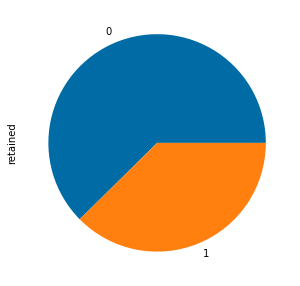

In [24]:
counts = df['retained'].value_counts()/len(df)
_ = counts.plot.pie(figsize=(5, 5))
counts

### 37.61% were detained

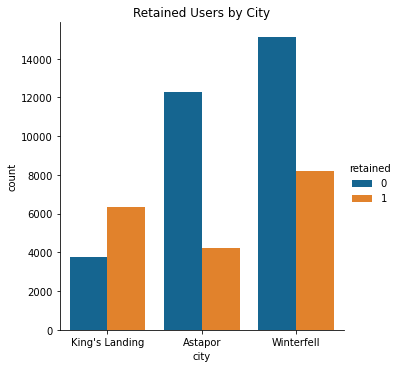

In [25]:
_ = sns.catplot(x = 'city', data=df, kind='count', hue='retained')
_ = plt.title('Retained Users by City')

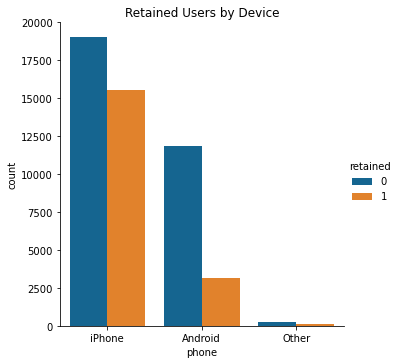

In [26]:
_ = sns.catplot(x = 'phone', data=df, kind='count', hue='retained')
_ = plt.title('Retained Users by Device')

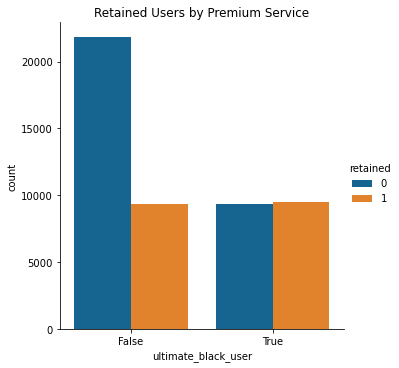

In [27]:
_ = sns.catplot(x = 'ultimate_black_user', data=df, kind='count', hue='retained')
_ = plt.title('Retained Users by Premium Service')

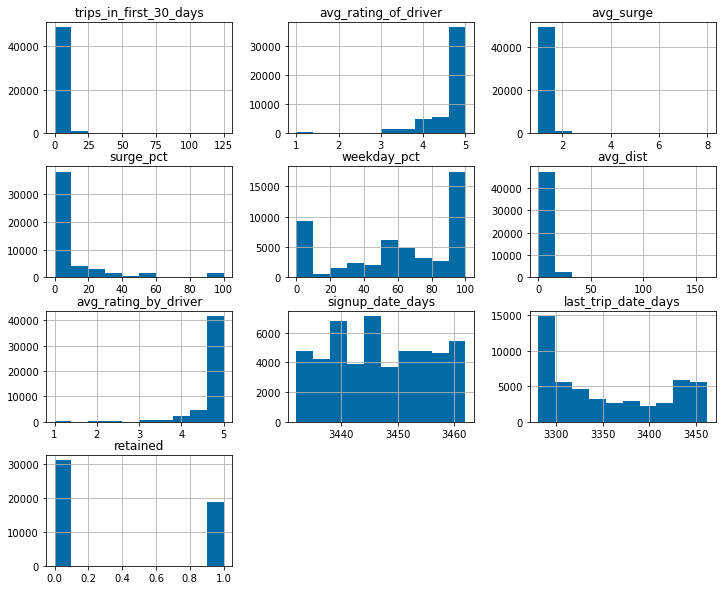

In [28]:
_ = df.hist(figsize=(12,10))

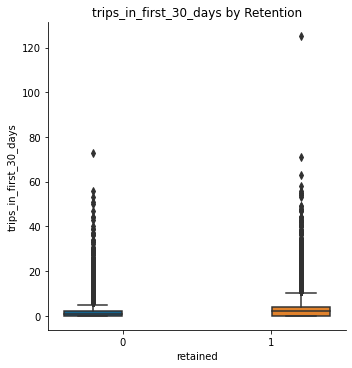

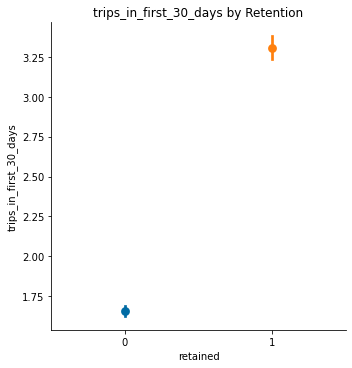

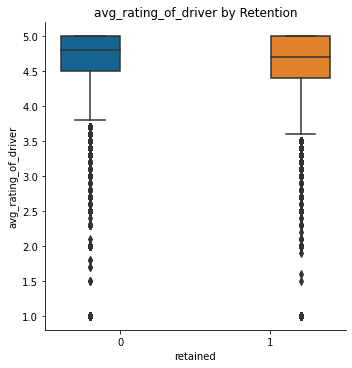

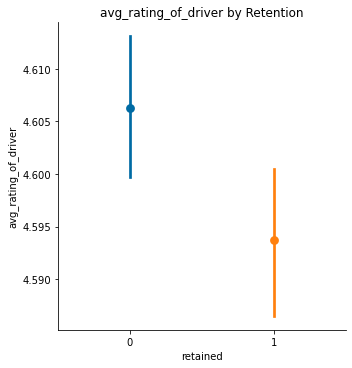

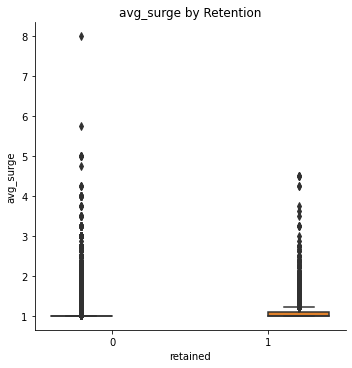

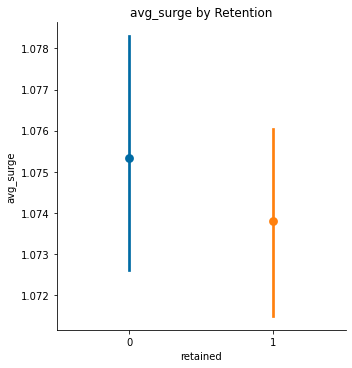

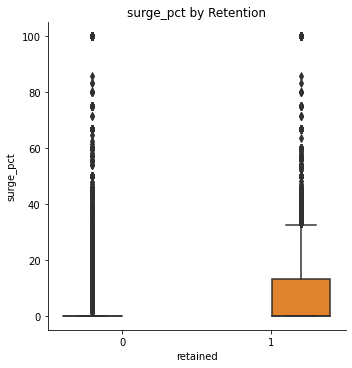

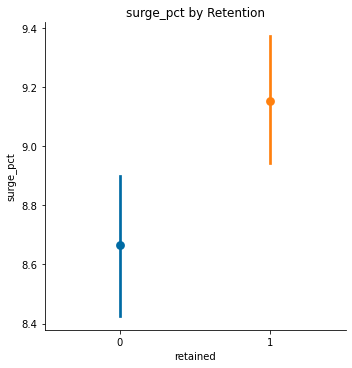

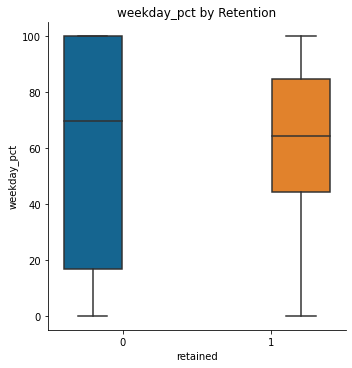

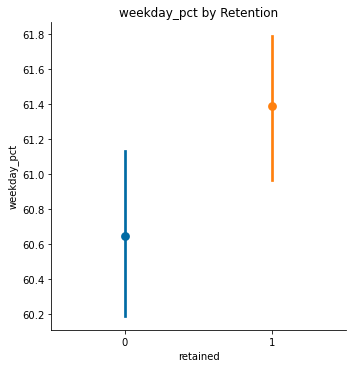

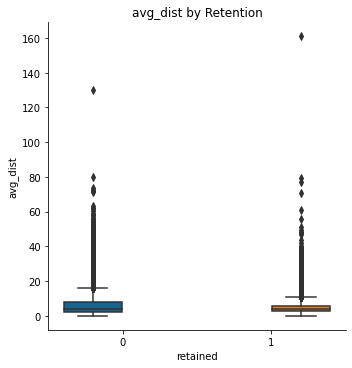

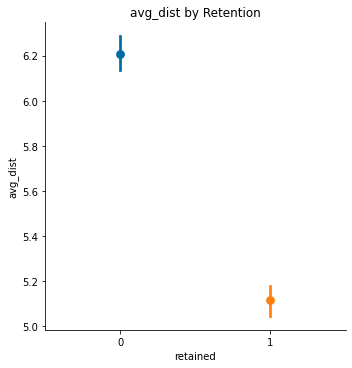

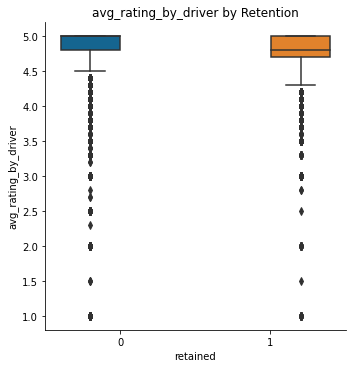

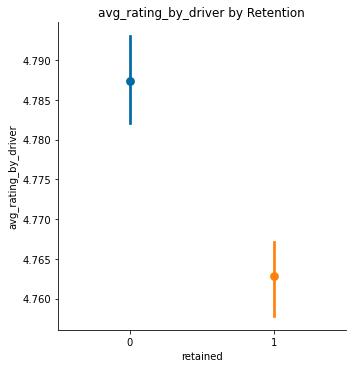

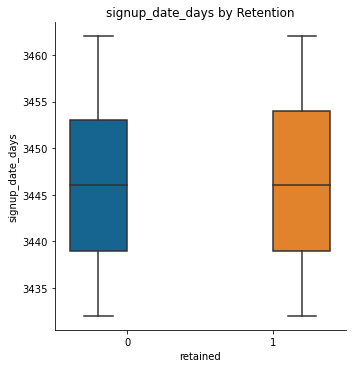

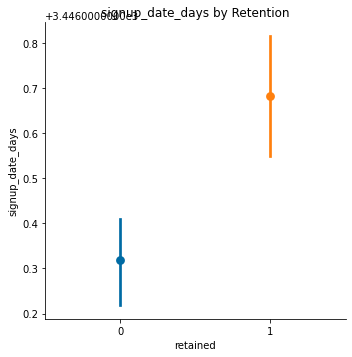

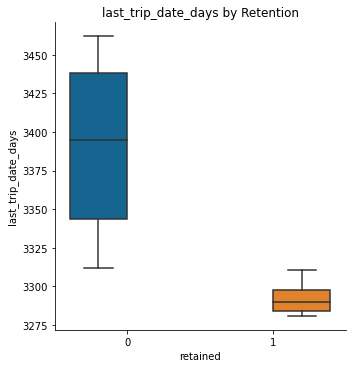

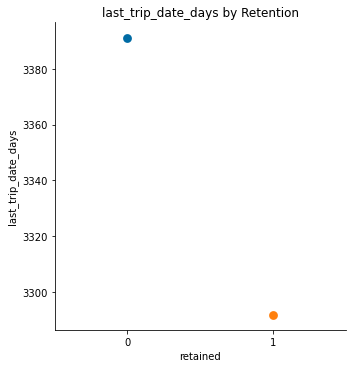

In [29]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
target = numeric_df.columns[-1]
for col in numeric_df.columns[:-1]:
    _ = sns.catplot(x = target, y = col, data=df, kind='box', hue='retained')
    _ = plt.title(f'{col} by Retention')
    _ = sns.catplot(x = target, y = col, data=df, kind='point', hue='retained')
    _ = plt.title(f'{col} by Retention')

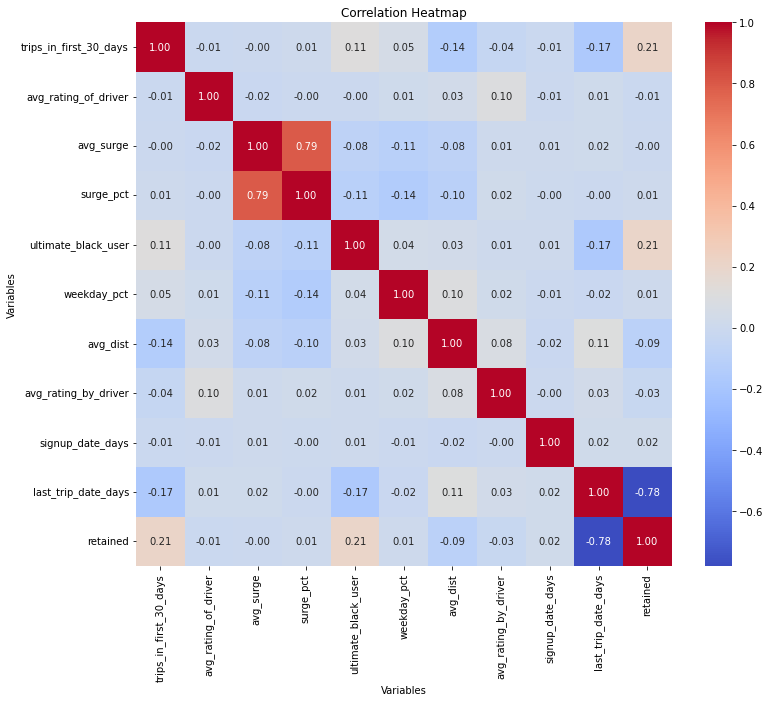

In [30]:
# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')

# Set plot title and labels
plt.title('Correlation Heatmap')
plt.xlabel('Variables')
plt.ylabel('Variables')

# Display the heatmap
plt.show()

In [31]:
df = pd.get_dummies(df)
df

trips_in_first_30_days  avg_rating_of_driver  avg_surge  surge_pct  \
0                           4              4.700000       1.10       15.4   
1                           0              5.000000       1.00        0.0   
2                           3              4.300000       1.00        0.0   
3                           9              4.600000       1.14       20.0   
4                          14              4.400000       1.19       11.8   
...                       ...                   ...        ...        ...   
49995                       0              5.000000       1.00        0.0   
49996                       1              4.601559       1.00        0.0   
49997                       0              5.000000       1.00        0.0   
49998                       2              3.000000       1.00        0.0   
49999                       0              4.601559       1.00        0.0   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  \
0                     True         46.2      3.67                   5.0   
1                    False         50.0      8.26                   5.0   
2                    False        100.0      0.77                   5.0   
3                     True         80.0      2.36                   4.9   
4                    False         82.4      3.13                   4.9   
...                    ...          ...       ...                   ...   
49995                False        100.0      5.63                   4.2   
49996                False          0.0      0.00                   4.0   
49997                 True        100.0      3.86                   5.0   
49998                False        100.0      4.58                   3.5   
49999                False          0.0      3.49                   5.0   

       signup_date_days  last_trip_date_days  retained  city_Astapor  \
0                  3438                 3295         1             0   
1                  3434                 3338         0             1   
2                  3457                 3456         0             1   
3                  3453                 3283         1             0   
4                  3436                 3389         0             0   
...                 ...                  ...       ...           ...   
49995              3438                 3307         1             0   
49996              3439                 3438         0             1   
49997              3432                 3321         0             0   
49998              3449                 3448         0             1   
49999              3445                 3353         0             1   

       city_King's Landing  city_Winterfell  phone_Android  phone_Other  \
0                        1                0              0            0   
1                        0                0              1            0   
2                        0                0              0            0   
3                        1                0              0            0   
4                        0                1              1            0   
...                    ...              ...            ...          ...   
49995                    1                0              0            0   
49996                    0                0              0            0   
49997                    0                1              1            0   
49998                    0                0              0            0   
49999                    0                0              1            0   

       phone_iPhone  
0                 1  
1                 0  
2                 1  
3                 1  
4                 0  
...             ...  
49995             1  
49996             1  
49997             0  
49998             1  
49999             0  

[50000 rows x 17 columns]

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  bool   
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   avg_rating_by_driver    50000 non-null  float64
 8   signup_date_days        50000 non-null  int64  
 9   last_trip_date_days     50000 non-null  int64  
 10  retained                50000 non-null  int64  
 11  city_Astapor            50000 non-null  uint8  
 12  city_King's Landing     50000 non-null  uint8  
 13  city_Winterfell         50000 non-null  uint8  
 14  phone_Android           50000 non-null

In [34]:
X = df.drop(columns = ['retained', 'last_trip_date_days'])
y = df['retained']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 10)

In [36]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

### Simple Logistic Regression

In [37]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

In [38]:
y_pred = model.predict(X_train)

/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [39]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     25000
           1       0.38      1.00      0.55     15000

    accuracy                           0.38     40000
   macro avg       0.19      0.50      0.27     40000
weighted avg       0.14      0.38      0.20     40000



/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
y_pred = model.predict(X_test)

/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6196
           1       0.38      1.00      0.55      3804

    accuracy                           0.38     10000
   macro avg       0.19      0.50      0.28     10000
weighted avg       0.14      0.38      0.21     10000



/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
rf = RandomForestClassifier(random_state = 42)

# Create param grid.

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Create grid search object

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit on data

best = rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  40.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  50.9s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  33.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  39.2s


/home/rana/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  15.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  55.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  36.7s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=  28.0s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  20.8s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=  41.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  37.7s
[CV] END bootstrap=False, max_depth=100,

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time= 1.5min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  31.8s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  14.6s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 1.2min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 1.1min
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  51.6s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  46.1s
[CV] END bootstrap=True, max

[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 1.3min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  22.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  27.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   5.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  12.5s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  39.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 1.5min
[CV] END bootstrap=True, max_depth=10

In [43]:
best.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [44]:
best.best_score_

0.7837249122318504

In [45]:
y_pred = best.predict(X_train)

In [46]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     25000
           1       0.78      0.68      0.72     15000

    accuracy                           0.81     40000
   macro avg       0.80      0.78      0.79     40000
weighted avg       0.80      0.81      0.80     40000



In [47]:
y_pred = best.predict(X_test)

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      6196
           1       0.75      0.64      0.69      3804

    accuracy                           0.78     10000
   macro avg       0.78      0.76      0.76     10000
weighted avg       0.78      0.78      0.78     10000



In [50]:
_ = print(best)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)


### Random Forest

In [51]:
rf = RandomForestClassifier(n_estimators= 400,
 min_samples_split= 10,
 min_samples_leaf= 4,
 max_features= 'auto',
 max_depth= 70,
 bootstrap= True).fit(X_train, y_train)

In [52]:
y_pred = best.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     25000
           1       0.78      0.68      0.72     15000

    accuracy                           0.81     40000
   macro avg       0.80      0.78      0.79     40000
weighted avg       0.80      0.81      0.80     40000



In [53]:
y_pred = best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      6196
           1       0.75      0.64      0.69      3804

    accuracy                           0.78     10000
   macro avg       0.78      0.76      0.76     10000
weighted avg       0.78      0.78      0.78     10000



/home/rana/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


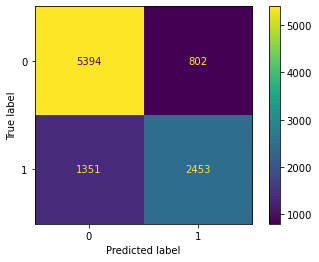

In [55]:
_ = plot_confusion_matrix(best, X_test, y_test)  
_ = plt.show()

### Conclusion

Fraction of Observed Users Retained:
37.68% of the observed users were retained.

Approach Summary:
The approach involved imputing missing values, creating a target feature for binary classification, visualizing feature-target relationships, transforming data types, and engineering features for modeling. A baseline logistic regression model was used, followed by testing a Random Forest Classifier. The model was evaluated, and feature importance was reviewed.

Model Summary:
The best-performing model was the Random Forest Classifier. A detailed RandomizedSearchCV was conducted to find the best parameters, resulting in a score of 69% for F1 (precision and recall balance) and 78% for accuracy. The best parameters included 'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 70, and 'bootstrap': True.

Concerns and Alternatives:
There is a need to improve recall or reduce false negatives to make predictions more risk-averse. Given more time, alternative approaches could be explored, such as using auto ML tools like Pycaret for faster experimentation with other models and hyperparameters. Ensemble methods could also be considered to potentially boost the model's performance and improve the overall F1 score. Alternatively, implementing BayesSearchCV for parameter selection could be explored to assess its impact on model performance.

Leveraging Insights:
Riders flagged for non-retention offer an opportunity for intervention through marketing and operations campaigns, potentially leading to increased revenue. Rider status can influence targeted marketing efforts. Notable features that influence predictions are riders taking early trips within the first 30 days, with around 3 trips indicating higher likelihood of retention. The rider's rating by the driver is another key indicator, with slightly lower average ratings being associated with higher retention likelihood. Additionally, a higher percentage of weekday trips and lower average trip distances among retained riders suggests they are more likely to be commuters. Lastly, the city of Kings Landing is an interesting region to focus on for customer acquisition experiments.